![X-Ray - Image CC0 - pexels.com](./img/pexels-anna-shvets-4226258.jpg)

Chest X-Ray encoder (CXRE)
==========================

Levi-dan Azoulay  
Nathane Berrebi  
Ali Bellamine

# Description

Chest radiography is a common imaging modality used to assess the thorax and the most common medical imaging study in the world.  
Chest radiographs are used to identify both acute and chronic cardiopulmonary conditions, verify that devices such as pacemakers, central lines, and tubes are correctly positioned, and to assist in related medical workups.  
In the U.S., the number of radiologists as a percentage of the physician workforce is decreasing and the geographic distribution of radiologists favors larger, more urban counties. Delays in timely medical imaging interpretation have demonstrably reduced care quality in such large health organizations as the U.K. National Health Service and the U.S. Department of Veterans Affairs. The situation is even worse in resource-poor areas, where radiology services are extremely scarce. As of 2015, only 11 radiologists served the 12 million people of Rwanda, while the entire country of Liberia, with a population of four million, had only two practicing radiologists.   

Accurate automated analysis of radiographs has the potential to improve the efficiency of radiologist workflow and extend expertise to under-served regions.
Large databases and ensuring deep-learning networks’ accuracy are a prior to deploying automated analysis tool. 

The MIMIC Chest X-ray (MIMIC-CXR) Database v2.0.0 is a large publicly available dataset of chest radiographs in DICOM format with free-text radiology reports. The dataset contains 377,110 images corresponding to 227,835 radiographic studies performed at the Beth Israel Deaconess Medical Center in Boston, MA. The dataset is de-identified to satisfy the US Health Insurance Portability and Accountability Act of 1996 Safe Harbor requirements. The dataset is intended to support a wide body of research in medicine including image understanding, natural language processing, and decision support.


# Project

Labelling a dataset is time-consuming and costly. Leveraging the most out of unlabeled and large databases is a current hot topic in deep learning, as most datasets remain unlabeled and asleep in data warehouses.

Our aim is to provide a proof-of-concept that an unsupervised pre-training of a network (classifier) can greatly improve its performances when compared to a naïve neural network. We also wish to assess the ability of an auto-encoder to project a complex information in a smaller latent space, which would make image manipulation and classification easier. 

- By unsupervised pre-training, we mean the training of an auto-encoder. The AE will take as input the images, and will learn to project and reconstruct the image. We will use a large database to train such an AE, that does not require any labelling.
- By classifier, we mean to use a Convolutional Network that will take the images as input, and will learn to predict the label (the anomaly, the disease) associated with that image. We will use a smaller database to train such a classifier, that does require labelling.

We will compare the performances of many different classifiers:
- Naïve CNN, without auto-encoder based on a mobilenet backend (CLASS_NAIVE)
- Classifier using the latent space of vanilla auto-encoder (CLASS_CXR_AE_1)
- Classifier using all the intermediates spaces of vanilla auto-encoder (CLASS_CXR_AE_1_MBLOCK)
- Classifier using the latent space of a two-outputs auto-encoder (CLASS_CXR_AE_2)
- Classifier using all the intermediates spaces of a two-outputs auto-encoder (CLASS_CXR_AE_2_MBLOCK)
- Classifier using the embedding reconstruction of a two-outputs auto-encoder (CLASS_CXR_AE_2_EMBEDDINGS)

**Although, the different classifier will be trained using the same labelled dataset, we hope to obtain greater performances with the pre-trained CNN (AE+CNN) than with the naïve CNN.**

# Downloading data

We work in a randomly picked sample of 2% the [MIMIC-IV-CXR database](https://physionet.org/content/mimic-cxr/2.0.0/).
We based our worked on a derivated database name [MIMIC-CXR-JPG](https://physionet.org/content/mimic-cxr-jpg/2.0.0/) in order to work from a homogenized way to transform DICOM images to JPG and to perform features extraction from report notes.

We will work with JPG images instead of DICOM raw images mainly because of our harware limitation in disk storage.

The download script is available for any review in `./download_mimic.py` but for conveniency we will directly provide the processed data.

In [15]:
import download_data

# Download the data
## Fill the token

token = "" # Fill the current line

#download_data.download_data(token=token, folder="./data") # Uncomment this line to download data

# Loading data

The downloaded data are available in the `./data` folder.  
It contains somes CSV files containing the `MIMIC-IV` image's metadata and annotations, image's report and images in a JPG format.  

To work easily with the image, we provided a `Dataset` class which abstract the dataloading and a `get_data` function which concatenate the metadata from CSV files and provide an X and y dataset.

In [2]:
from utils.preprocessing import get_data
from matplotlib import pyplot as plt

X, y, X_annotated, y_annotated = get_data("./data", annotations_path="./data/annotations_08032021.zip", split_annotation=True)

## Images and images' metadata

The get_data function return a tuple X and y, X is a tuple containing the images' Dataset and metadata, y contains the labels.

The images are Chest Radiographie.  
There is a wide heterogeneity in this kind of images, we can distinguish :
- Frontal chest Classical X-Ray
- Lateral chest Classical X-Ray
- Frontal chest Portable X-Ray
- Lateral chest Portable X-Ray
- Frontal X-Ray in lying position

Indeed, a good quality radiography should be performed in a standing position, but when it is not possible it is done in a lying position, which gives a totally different image.  
Let's look at somes images.

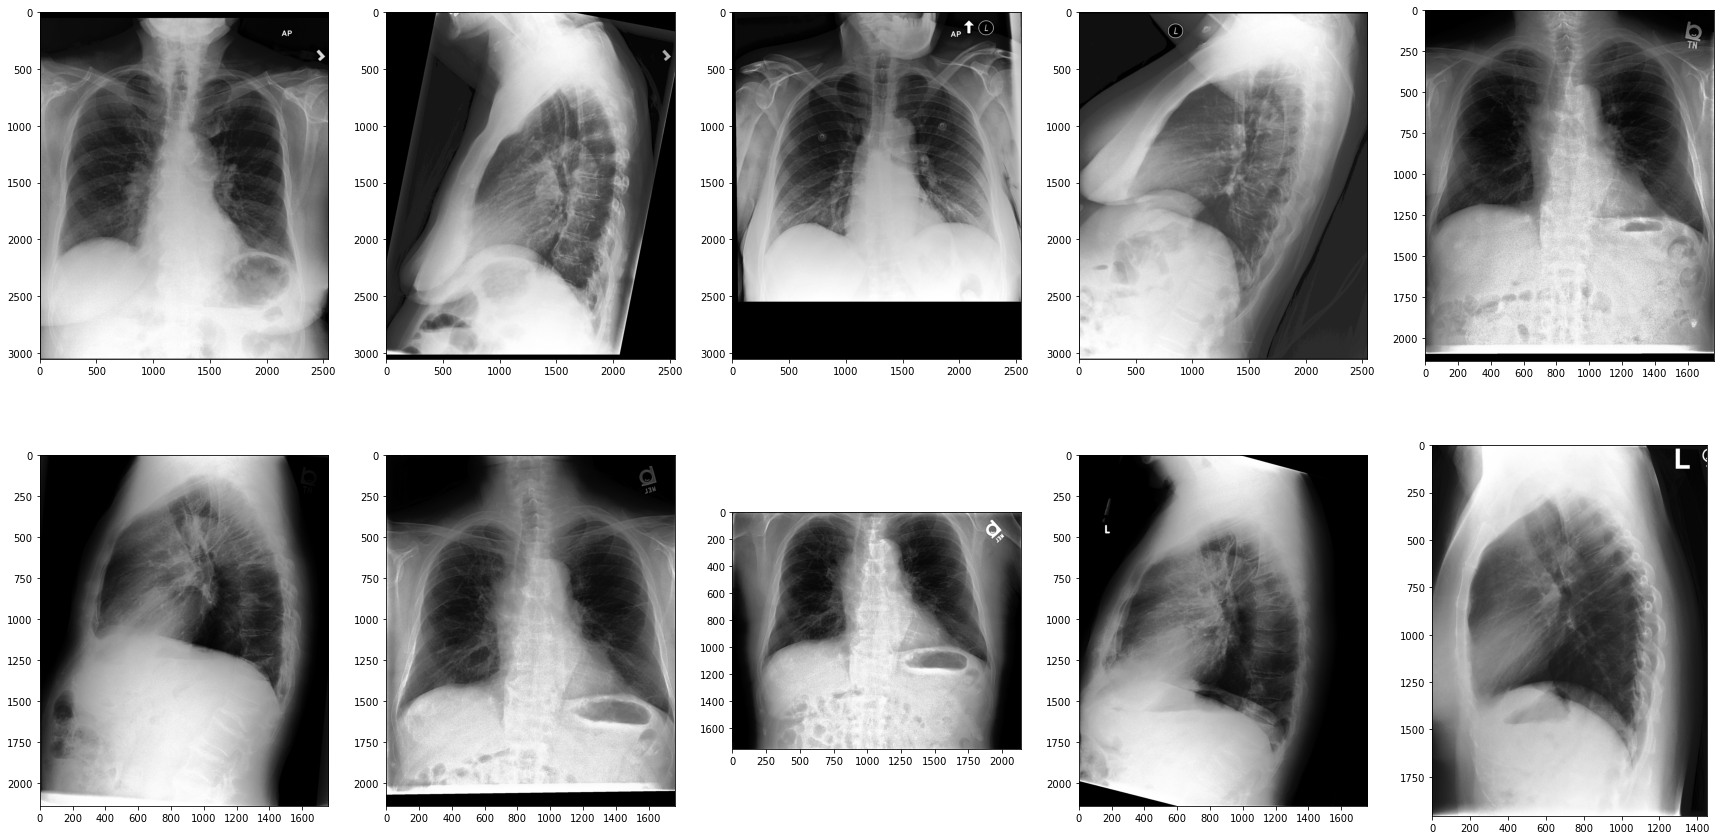

In [3]:
fig, axs = plt.subplots(2,5, figsize=(30,15))
axs = axs.flatten()

for i in range(10):
    image = X[0][i][0]
    axs[i].imshow(image, cmap="gray")

The images metadata contains the image size, the position of the patient during the acquisition and the kind of acquisition (classifical or portable).  
In a first time, we will not use this information and focus in the image to explore somes Deep Learning method.

In [ ]:
X[1].head(5)

,uid,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,0,19e55bee-714bb193-0968d683-5bf655a5-7b5caba9,10001401,58747570,CHEST (PA AND LAT),PA,3056,2544,21310730,134837.843,CHEST (PA AND LAT),postero-anterior,Erect
1,1,f56a3d51-284b2466-262661f1-2567a6ab-248f4ae3,10001401,58747570,CHEST (PA AND LAT),LATERAL,3056,2544,21310730,134837.843,CHEST (PA AND LAT),lateral,Erect
2,2,84c6ecc4-fd81e31d-1e879d18-13024211-35de54ad,10002930,55885481,CHEST (PA AND LAT),AP,3056,2544,21980417,152156.609,CHEST (PA AND LAT),antero-posterior,Erect
3,3,eb71d6af-79edf48e-4fecee5b-133fa0e2-614d733f,10002930,55885481,CHEST (PA AND LAT),LATERAL,3056,2544,21980417,152156.609,CHEST (PA AND LAT),lateral,Erect
4,4,291d51fa-d786f2a5-7519f2fa-409c3d4a-6465003c,10003019,52117631,CHEST (PA AND LAT),NaN,2140,1760,21750704,105319.000,CHEST (PA AND LAT),NaN,NaN


## Labels

The label dataframe contains :
- Image reports / Segmented image report
- MIMIC-CXR-JPG images labels
- Our custom labels

### Images reports

Each image is associated with a `study_id`. This id is an unique examination id containing one or more images.  
For each `study_id` is provided an unique examination report that we stored in the `y` Dataframe.  
We can see, and verify, that the report are well structured.

In [ ]:
# An example of report
print(y["report"][10])

                                 FINAL REPORT
 INDICATION:  Cough for one year.
 
 No comparison studies available.
 
 FRONTAL AND LATERAL CHEST RADIOGRAPHS:  The heart size is normal.  The hilar
 and mediastinal contours are within normal limits.  There is no pneumothorax,
 focal consolidation, or pleural effusion.
 
 IMPRESSION:  Normal chest radiograph.



Thus, we provided in the `get_data` function some basic regex text segmentation in the following columns :

In [ ]:
reports_columns = [x for x in y.columns if x.startswith("report_")]
print(reports_columns)

['report_extra', 'report_comparison', 'report_findings', 'report_impression', 'report_indication', 'report_reason_for_exam', 'report_reason_for_examination']


### MIMIC-CXR-JPG images labels

The MIMIC-CXR-JPG database provide some labels about the main disease in the image, these are stored in the `y` Dataframe.  
A 1 is expected when a disease is described, -1 when its presence is ambigeous.

In [ ]:
labels = y.columns[3:17].tolist()
y[labels].sum().astype("int")

Atelectasis                    881
Cardiomegaly                   932
Consolidation                  126
Edema                          299
Enlarged Cardiomediastinum     -32
Fracture                       100
Lung Lesion                    186
Lung Opacity                  1177
No Finding                    2537
Pleural Effusion              1184
Pleural Other                   39
Pneumonia                      -16
Pneumothorax                   200
Support Devices               1482
dtype: int32

These labels are provided given a Natural Langage Processing algorithm. We explored whether these were reliable by reading some documents and noticed that the negation detection was no accurate.  
Here is a well chosen examples :

In [ ]:
print(
    y.loc[250, "report"]
)
tmp_labels = y.loc[250, "text_label"]
print(f"Labels : {tmp_labels}")
# A pneumothorax is detected even is it written "no pneumothorax"

                                 FINAL REPORT
 PORTABLE CHEST FILM, ___ AT 11:41
 
 CLINICAL INDICATION:  ___-year-old with bifrontal glioblastoma and seizures
 with possible UTI, question pneumonia.
 
 Comparison to ___ at ___.
 
 AP portable supine chest film, ___ at 11:41 is submitted.
 
 IMPRESSION:
 
 Right-sided Port-A-Cath remains in place with tip in the distal SVC.  Overall
 cardiac and mediastinal contours are unchanged.  Linear opacity at the left
 base most likely reflects subsegmental atelectasis or scarring.  No focal
 airspace consolidation seen to suggest pneumonia.  No pleural effusions or
 pulmonary edema.  No pneumothorax, although the sensitivity to detect
 pneumothorax is diminished given supine technique.

Labels : Atelectasis,Enlarged Cardiomediastinum,Lung Opacity,Pneumothorax


### Our custom labels

We thus decided to annotate the dataset in order to get reliable labels.  
We performed somes annotations according to the images' report using an instance of `doccano` annotation tool.  
Theses annotations are integrated in the `y` by the `get_data` function. We added a parameter to separate the images with and without annotations.  
Thus, all the annotations are stored in the `y_annotated` dataframe.  
We annotated a total of 560 reports which correspond to 932 imahes.

In [ ]:
custom_labels = [x for x in y_annotated.columns if x.startswith("annotation")]
y_annotated[custom_labels].sum().astype("int")

annotation_Cardiomégalie                   169
annotation_Oedeme pulmonaire               120
annotation_Epanchement pleural             202
annotation_Atelectasie                     196
annotation_Surveillance matériel           269
annotation_Autres                          102
annotation_Pneumothorax                     24
annotation_Infection respiratoire basse     78
annotation_Normal                          365
dtype: int32

Let's confirm our insight about the NLP-based labels :

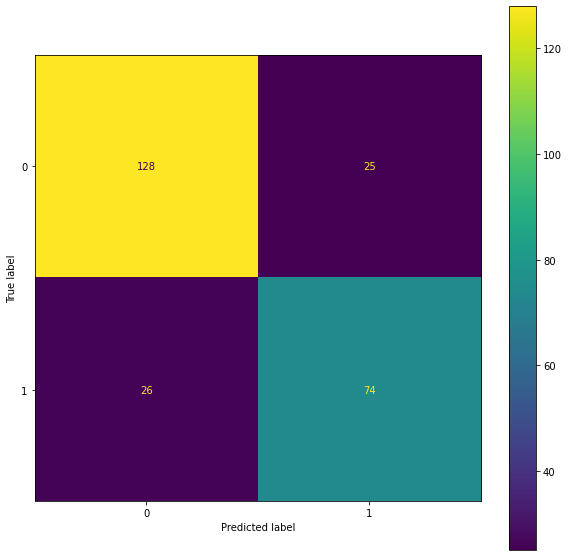

In [ ]:
# Example on Edema : Left = NLP based label, Right = Custom annotation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
new_label = "annotation_Oedeme pulmonaire"
old_label = "Edema"
tmp_y_annotated = y_annotated[[new_label, old_label]].dropna()

fix, ax = plt.subplots(1,1, figsize=(10,10))
ConfusionMatrixDisplay(
    confusion_matrix(
        tmp_y_annotated[new_label], 
        tmp_y_annotated[old_label].replace(-1, 0)
    )
).plot(ax=ax)
plt.show()

# Auto-encoder

We train two denoising auto-encoder network :
- 1. Image auto-encoder (**CXR_AE_1**)
- 2. Image + embedding auto-encoder (**CXR_AE_2**)

The first be based on a Conv-Deconv architecture with an **image reconstruction** loss function based on a **mean square error**.  
The second will be the same as the first, but we will also try to reconstruct the embeddings of the **Impressions** subpart of the report from the latent space.  
Both are based on U-NET architecture.

The main idea behind this is to force the auto-encoder to focus on **clinical** relevant information.
The documents embeddings will be produced according to the `bert-base-uncased` from the `Huggingface` implementation.  
We choosed to work with a `BERT` model because we need to get a contextual embedding to increase the ability of the system to distringuish between relevant and non relevant information. We choosed the `uncased` because we did not notice an importance of the Case during our annotation.

The auto-encoder will be only trained on non-annotated data.

In [4]:
import os
import torch
import numpy as np
from utils.autoencoders_unet import cxr_unet_ae_1, cxr_unet_ae_2
from utils.image_processing import get_collater
from utils.training import train_model
from utils.evaluation import display_predictions
from utils.text_processing.base import get_documents_embeddings
from utils.text_processing.bert import BertEmbedder

In [5]:
noise_variance = 1e-1
salt_and_pepper_noise = 0.2

## Training CXR_AE_1

In [6]:
cxr_ae_1_unet_path = "./models/cxr_ae_1_unet_v1.model"
pretrained = True
cxr_ae_1_unet_model = cxr_unet_ae_1(noise_variance=noise_variance, p_salt_pepper_noise=salt_and_pepper_noise)

In [7]:
if pretrained:
    cxr_ae_1_unet_model.load_model(cxr_ae_1_unet_path)
    print("Model loaded")
else:
    train_model(
        cxr_ae_1_unet_model,
        X=X[0],
        y=None,
        n_epoch=5,
        batch_size=4,
        collater_fn_x=get_collater(size=256, crop=True, rotate=True),
        collater_fn_y=None,
        use_gpu_if_available=True,
        loss_names=["Reconstruction loss"]
    )
    cxr_ae_1_unet_model.save_model(cxr_ae_1_unet_path)

Model loaded


## Training CXR_AE_2

In [10]:
cxr_ae2_unet_path = "./models/cxr_ae_2_unet_v1.model"
pretrained = True
cxr_ae_2_unet_model = cxr_unet_ae_2(embedding_size=768, noise_variance=noise_variance, p_salt_pepper_noise=salt_and_pepper_noise)

In [11]:
if pretrained:
    cxr_ae_2_unet_model.load_model(cxr_ae2_unet_path)
    print("Model loaded")
else:
    bert_embedder = BertEmbedder(preprocessing=False, batch_size=128, use_gpu_if_available=True)
    y_embeddings = tuple([torch.tensor(get_documents_embeddings(y, bert_embedder, column), dtype=torch.float32) for column in ["report_findings", "report_impression"]])

    train_model(
        cxr_ae_2_unet_model,
        X=X[0],
        y=y_embeddings[1],
        n_epoch=20,
        batch_size=4,
        collater_fn_x=get_collater(size=256, crop=True, rotate=True),
        collater_fn_y=None,
        use_gpu_if_available=True,
        loss_names=["Reconstruction loss", "Embedding Loss"],
    )

    cxr_ae_2_unet_model.save_model(cxr_ae2_unet_path)

Model loaded


## Visual check

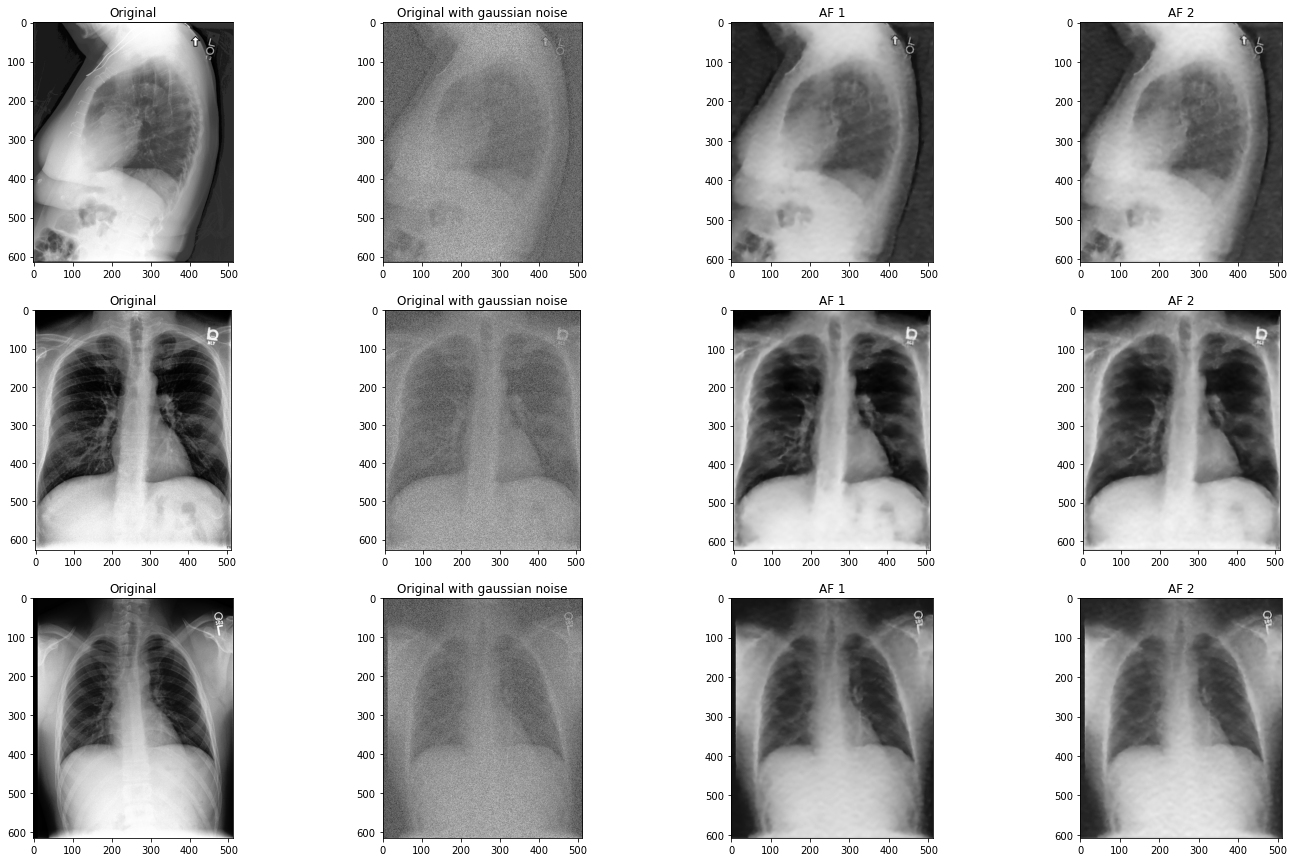

In [14]:
display_predictions(
    X[0],
    [cxr_ae_1_unet_model, cxr_ae_2_unet_model],
    device="cuda"
)

# Images Classifier

We will compare the performances of many different classifiers:
- Naïve CNN, without auto-encoder based on a mobilenet backend (CLASS_NAIVE)
- Classifier using the latent space of vanilla auto-encoder (CLASS_CXR_AE_1)
- Classifier using all the intermediates spaces of vanilla auto-encoder (CLASS_CXR_AE_1_MBLOCK)
- Classifier using the latent space of a two-outputs auto-encoder (CLASS_CXR_AE_2)
- Classifier using all the intermediates spaces of a two-outputs auto-encoder (CLASS_CXR_AE_2_MBLOCK)
- Classifier using the embedding reconstruction of a two-outputs auto-encoder (CLASS_CXR_AE_2_EMBEDDINGS)

The main metrics are :
- Accuracy
- F1-Score (micro)
- Precision (micro)
- Recall (micro)

In [19]:
from utils.classifiers import naiveImageClassifierMobileNet, MBlockAEClassifier, AEClassifier, AEClassifier_Embeddings
from utils.training import get_prediction
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

## Train-Test splitting

To prevent data-leakage, the train-test split is done according to the `study_id`.
Because we want to benchmark the performances in order to evaluate the auto-encoder strategy, we will drop lateral radiography for simplicity reason. 

In [16]:
study_id_train, study_id_test = train_test_split(X_annotated[1]["study_id"].unique(), test_size=0.2, random_state=42)
labels = [x for x in y_annotated.columns if x.startswith("annotation")]

# Getting train and test uids
uid_train = X_annotated[1][X_annotated[1]["study_id"].isin(study_id_train)].query("ViewPosition.isin(['AP','PA'])", engine="python")["uid"].values.tolist()
uid_test = X_annotated[1][X_annotated[1]["study_id"].isin(study_id_train) == False].query("ViewPosition.isin(['AP','PA'])", engine="python")["uid"].values.tolist()

X_train = X_annotated[0].split(uid_list=uid_train)[0]
y_train = y_annotated.set_index("uid").loc[uid_train, labels]
X_test = X_annotated[0].split(uid_list=uid_test)[0]
y_test = y_annotated.set_index("uid").loc[uid_test, labels]

We also computed balanced class weight to deal with the class imbalanced problem.

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

y_train_filtered = y_train.values
weights = []
for i in range(y_train_filtered.shape[1]):
    weights.append(
        compute_class_weight('balanced', classes=np.unique(y_train_filtered[:, i]), y=y_train_filtered[:, i])
    )
weights = np.stack(weights).T
weights = torch.clamp(torch.tensor(weights), min=0.2, max=5).numpy() # Clamping weights
weights = torch.tensor(weights, dtype=torch.float32).to(device)

## Training

In [22]:
classification_models = {}

### Training CLASS_NAIVE

In [28]:
class_naive_path = "./models/class_naive.model"
classification_models["CLASS_NAIVE"] = naiveImageClassifierMobileNet(n_labels=len(labels), weight_balance=True, weights=weights)
pretrained = True

In [29]:
if pretrained:
    classification_models["CLASS_NAIVE"].load_model(class_naive_path)
    print("Model loaded")
else:
    train_model(
        classification_models["CLASS_NAIVE"],
        X=X_train,
        y=torch.tensor(y_train.values, dtype=torch.float32),
        n_epoch=50,
        batch_size=4,
        collater_fn_x=get_collater(size=512, crop=True, resize_crop=False, rotate=False),
        collater_fn_y=None,
        use_gpu_if_available=True,
        loss_names=["BCE Loss"],
    )

    classification_models["CLASS_NAIVE"].save_model(class_naive_path)

Model loaded


### Training CLASS_CXR_AE_1

In [31]:
class_cxr_ae_1 = "./models/class_cxr_ae_1.model"
classification_models["CLASS_CXR_AE_1"] = AEClassifier(
    pretrained=cxr_ae_1_unet_model, 
    n_labels=len(labels), 
    weight_balance=True, 
    weights=torch.tensor(weights).to(device), 
    train_ae=True
)
pretrained = True

/tmp/ipykernel_540101/356624387.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights=torch.tensor(weights).to(device),


In [34]:
if pretrained:
    classification_models["CLASS_CXR_AE_1"].load_model(class_cxr_ae_1)
    print("Model loaded")
else:
    train_model(
        classification_models["CLASS_CXR_AE_1"],
        X=X_train,
        y=torch.tensor(y_train.values, dtype=torch.float32),
        n_epoch=50,
        batch_size=4,
        collater_fn_x=get_collater(size=512, crop=True, resize_crop=False, rotate=False),
        collater_fn_y=None,
        use_gpu_if_available=True,
        loss_names=["BCE Loss"],
    )

    classification_models["CLASS_CXR_AE_1"].save_model(class_cxr_ae_1)

Model loaded


### Training CLASS_CXR_AE_1_MBLOCK

In [357]:
class_cxr_ae_1_mblock = "./models/class_cxr_ae_1_mblock.model"
classification_models["CLASS_CXR_AE_1_MBLOCK"] = MBlockAEClassifier(
    pretrained=cxr_ae_1_unet_model, 
    n_labels=len(labels), 
    weight_balance=True, 
    weights=torch.tensor(weights).to(device), 
    train_ae=True
)

/tmp/ipykernel_540101/1667653622.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights=torch.tensor(weights).to(device),


In [358]:
if pretrained:
    classification_models["CLASS_CXR_AE_1_MBLOCK"].load_model(class_cxr_ae_1_mblock)
    print("Model loaded")
else:
    train_model(
        classification_models["CLASS_CXR_AE_1_MBLOCK"],
        X=X_train,
        y=torch.tensor(y_train.values, dtype=torch.float32),
        n_epoch=50,
        batch_size=4,
        collater_fn_x=get_collater(size=512, crop=True, resize_crop=False, rotate=False),
        collater_fn_y=None,
        use_gpu_if_available=True,
        loss_names=["BCE Loss"],
    )

    classification_models["CLASS_CXR_AE_1_MBLOCK"].save_model(class_cxr_ae_1_mblock)

Model loaded


### Training CLASS_CXR_AE_2

In [353]:
class_cxr_ae_2 = "./models/class_cxr_ae_2.model"
classification_models["CLASS_CXR_AE_2"] = AEClassifier(
    pretrained=cxr_ae_2_unet_model, 
    n_labels=len(labels), 
    weight_balance=True, 
    weights=torch.tensor(weights).to(device), 
    train_ae=True
)
pretrained = True

/tmp/ipykernel_540101/1171163255.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights=torch.tensor(weights).to(device),


In [349]:
if pretrained:
    classification_models["CLASS_CXR_AE_2"].load_model(class_cxr_ae_2)
    print("Model loaded")
else:
    train_model(
        classification_models["CLASS_CXR_AE_2"],
        X=X_train,
        y=torch.tensor(y_train.values, dtype=torch.float32),
        n_epoch=50,
        batch_size=4,
        collater_fn_x=get_collater(size=512, crop=True, resize_crop=False, rotate=False),
        collater_fn_y=None,
        use_gpu_if_available=True,
        loss_names=["BCE Loss"],
    )

    classification_models["CLASS_CXR_AE_2"].save_model(class_cxr_ae_2)

Model loaded


### Training CLASS_CXR_AE_2_MBLOCK

In [359]:
class_cxr_ae_2_mblock = "./models/class_cxr_ae_2_mblock.model"
classification_models["CLASS_CXR_AE_2_MBLOCK"] = MBlockAEClassifier(
    pretrained=cxr_ae_2_unet_model, 
    n_labels=len(labels), 
    weight_balance=True, 
    weights=torch.tensor(weights).to(device), 
    train_ae=True
)

/tmp/ipykernel_540101/3034140751.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights=torch.tensor(weights).to(device),


In [360]:
if pretrained:
    classification_models["CLASS_CXR_AE_2_MBLOCK"].load_model(class_cxr_ae_2_mblock)
    print("Model loaded")
else:
    train_model(
        classification_models["CLASS_CXR_AE_2_MBLOCK"],
        X=X_train,
        y=torch.tensor(y_train.values, dtype=torch.float32),
        n_epoch=50,
        batch_size=4,
        collater_fn_x=get_collater(size=512, crop=True, resize_crop=False, rotate=False),
        collater_fn_y=None,
        use_gpu_if_available=True,
        loss_names=["BCE Loss"],
    )

    classification_models["CLASS_CXR_AE_2_MBLOCK"].save_model(class_cxr_ae_2_mblock)

Model loaded


### Training CLASS_CXR_AE_2_EMBEDDINGS

In [58]:
class_cxr_ae_2_embeddings = "./models/class_cxr_ae_2_embeddings.model"
classification_models["CLASS_CXR_AE_2_EMBEDDINGS"] = AEClassifier_Embeddings(
    pretrained=cxr_ae_2_unet_model, 
    n_labels=len(labels), 
    weight_balance=True, 
    weights=torch.tensor(weights).to(device), 
    train_ae=True
)
pretrained = True

/tmp/ipykernel_540101/485723293.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights=torch.tensor(weights).to(device),


In [59]:
if pretrained:
    classification_models["CLASS_CXR_AE_2_EMBEDDINGS"].load_model(class_cxr_ae_2_embeddings)
    print("Model loaded")
else:
    train_model(
        classification_models["CLASS_CXR_AE_2_EMBEDDINGS"],
        X=X_train,
        y=torch.tensor(y_train.values, dtype=torch.float32),
        n_epoch=50,
        batch_size=4,
        collater_fn_x=get_collater(size=512, crop=True, resize_crop=False, rotate=False),
        collater_fn_y=None,
        use_gpu_if_available=True,
        loss_names=["BCE Loss"],
    )

    classification_models["CLASS_CXR_AE_2_EMBEDDINGS"].save_model(class_cxr_ae_2_embeddings)

Model loaded


## Get performances

In [384]:
from utils.evaluation import plot_performances, get_prediction_dict
import seaborn as sns

In [379]:
predictions = get_prediction_dict(classification_models, X_test)

Predictions: 100%|██████████| 122/122 [00:12<00:00, 10.14batch/s]


/home/ali/.miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


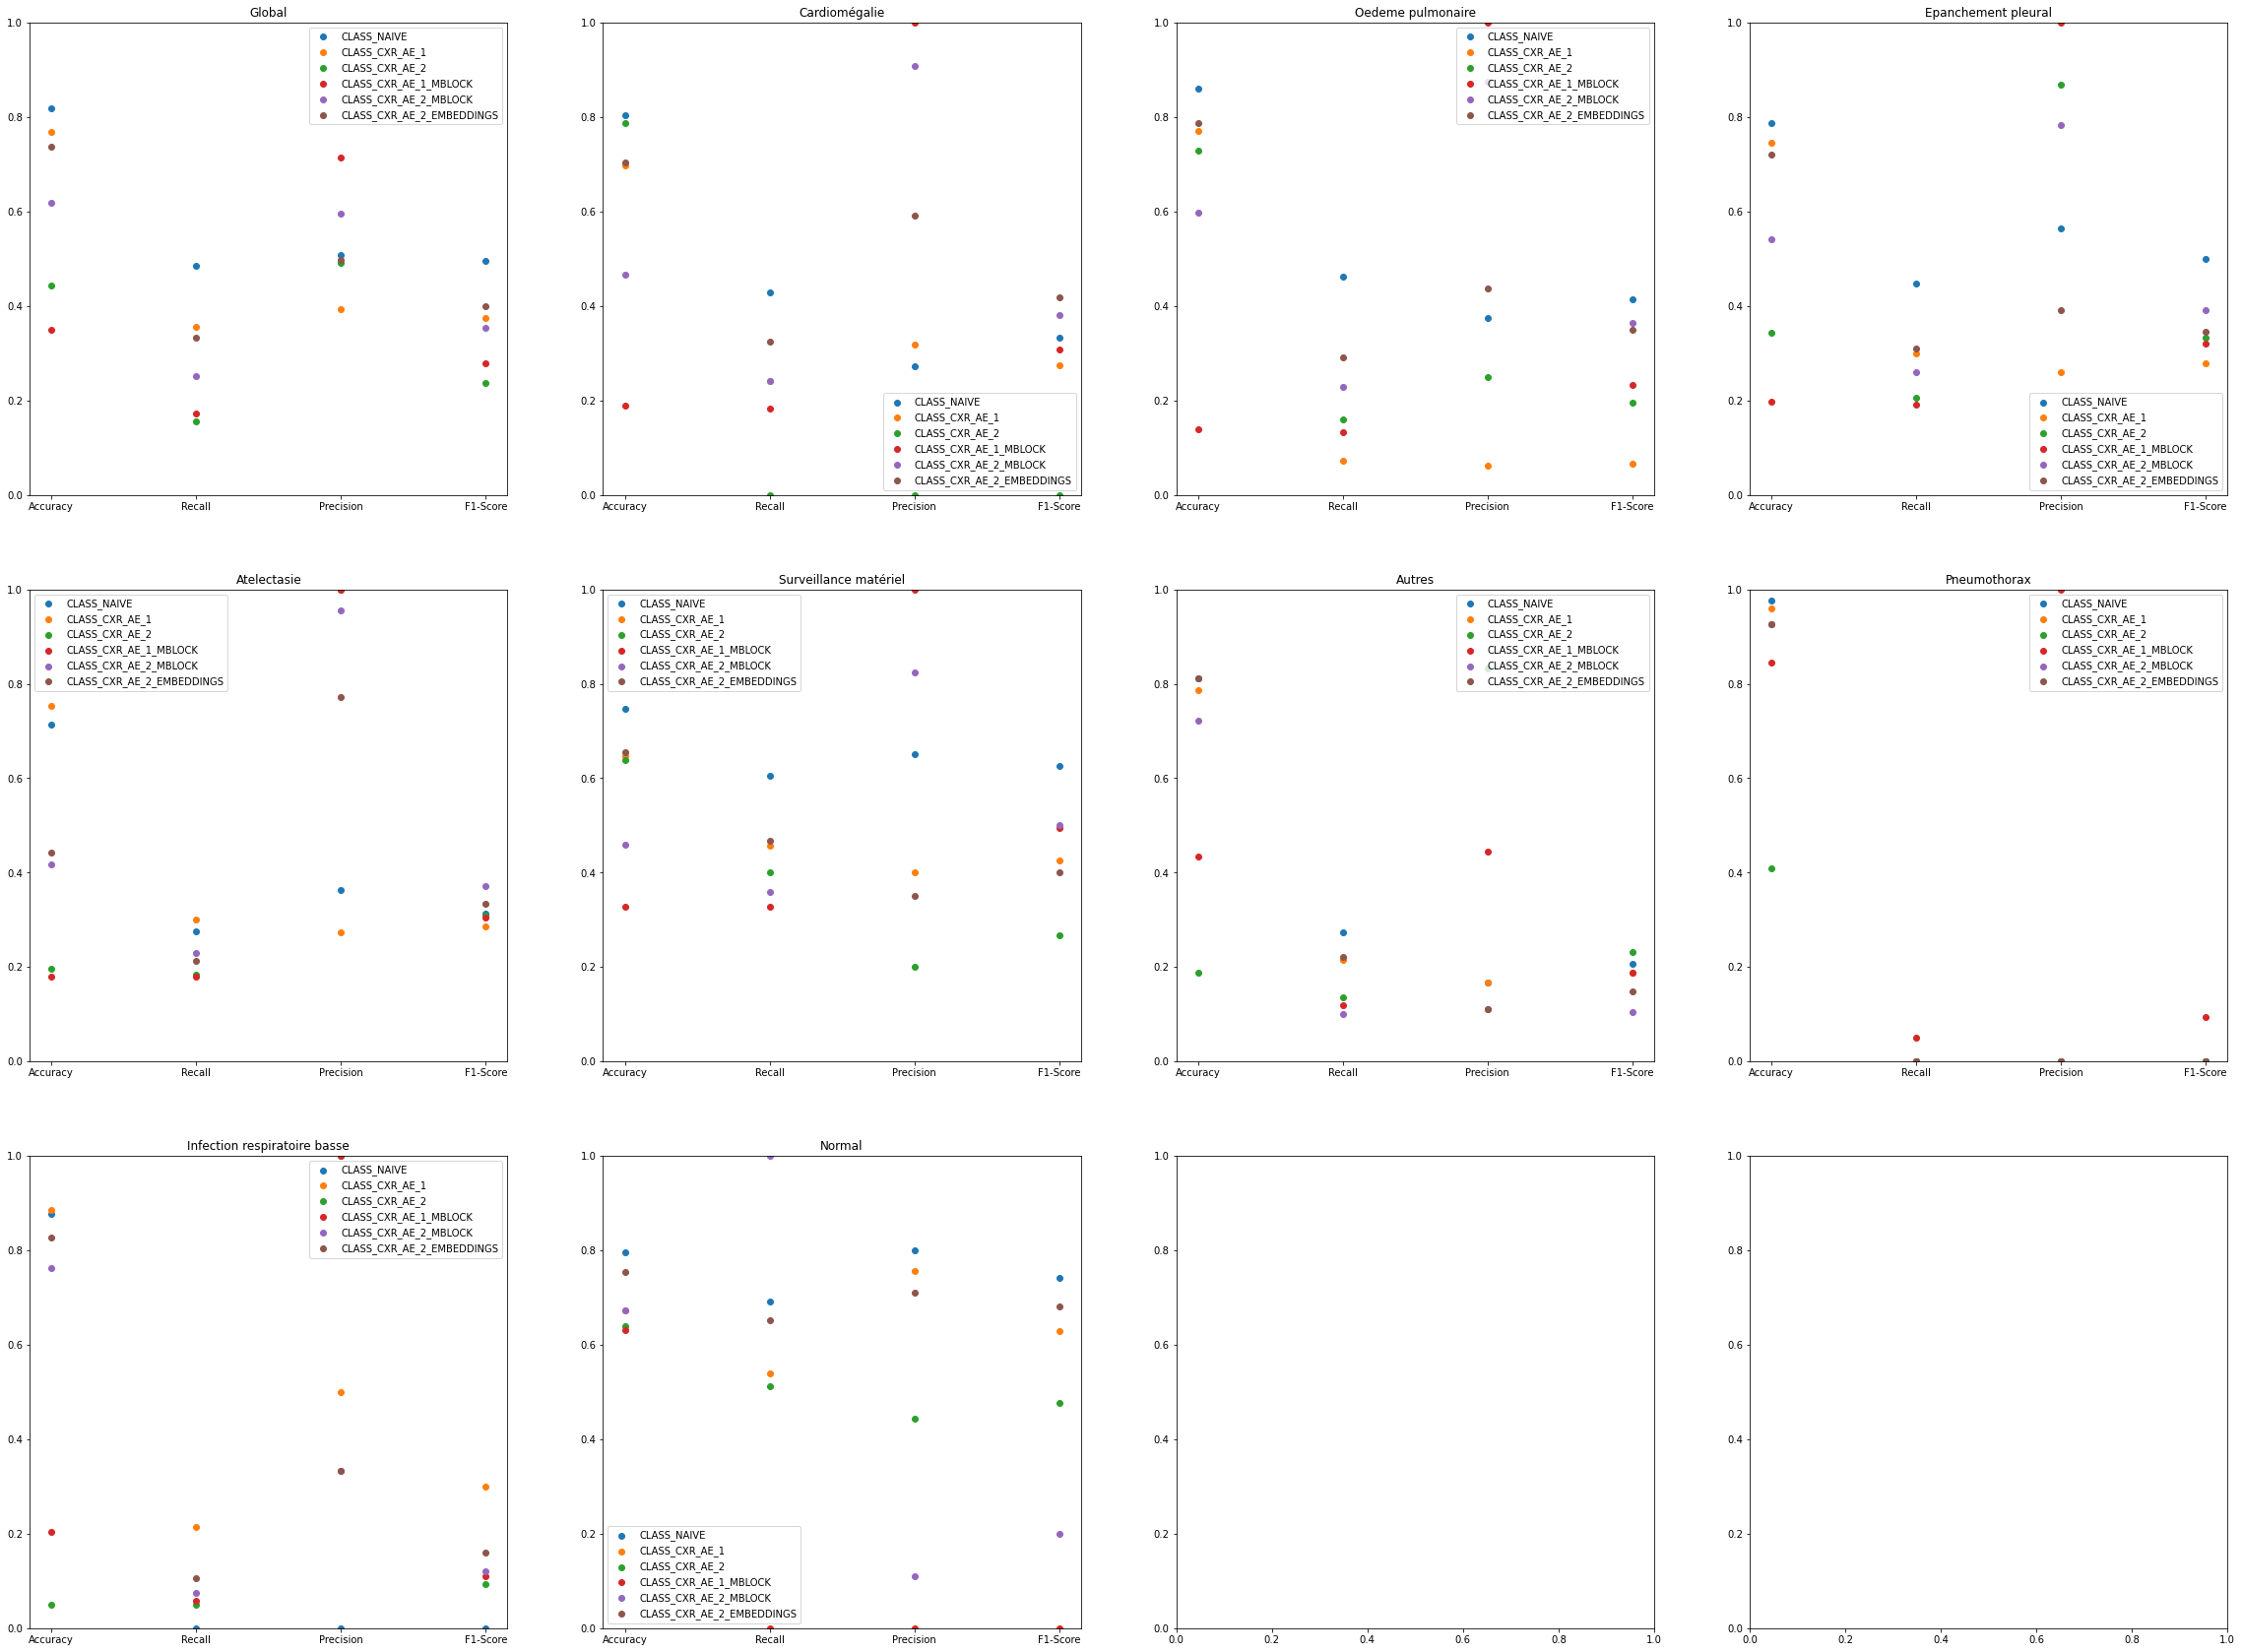

In [385]:
predictions_table = plot_performances(predictions=predictions, y_true=y_test, n_cols=4)

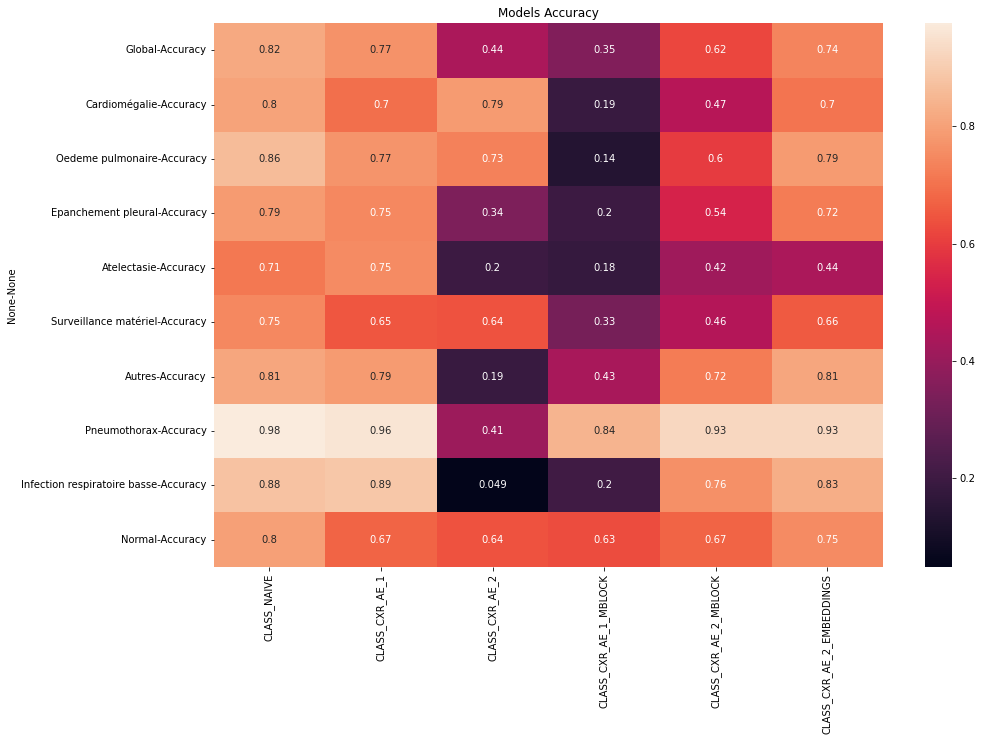

In [386]:
plt.figure(figsize=(15, 10))

accuracy_columns_mask = [x[1] in ["Accuracy"] for x in predictions_table.columns]
sns.heatmap(predictions_table.iloc[:, accuracy_columns_mask].T, annot=True)
plt.title("Models Accuracy")
plt.show()

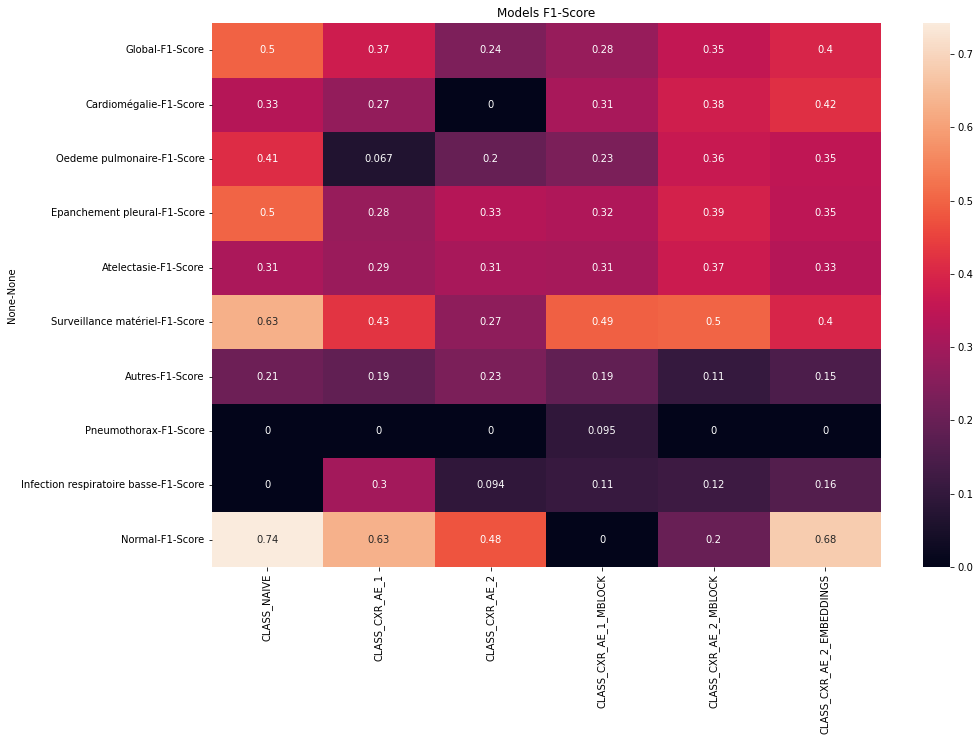

In [387]:
plt.figure(figsize=(15, 10))

accuracy_columns_mask = [x[1] in ["F1-Score"] for x in predictions_table.columns]
sns.heatmap(predictions_table.iloc[:, accuracy_columns_mask].T, annot=True)
plt.title("Models F1-Score")
plt.show()